# O2SLS

In [1]:
import numpy as np
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
from tqdm import tqdm

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [2]:
def sherman_morrison(invA, u, v):
    d = u.shape[0]
    u = u.reshape(d,1)
    v = v.reshape(d,1)
    return  invA - (invA @ u @ v.T @ invA)/(1 + v.T @ invA @ u)

In [4]:
## PARAMETERS 
n_iters = 50
T = int(1e3)
sigma_1, sigma_2 = 0.1, 0.1
rho = 1-2*np.random.binomial(1, 0.2, T) #np.random.binomial(1, 0.6, T) #np.array([2]) #1-2*np.random.binomial(1, 0.5, T)
d, lamda, lamda_IV = 1, 1e-2, 1e-2 #lamdas[index_reg]  # coordinate dimension, regularization
methods = ['Ridge','O2SLS', "Vovk-Azoury-Warmuth", 'Oracle']  # 'Oracle' is using the true parameter
online_loss_oracle = np.zeros((n_iters, len(methods), T))
online_loss_identification = np.zeros((n_iters, len(methods), T))

np.random.seed(23)

theta_star = np.random.randn(d,d) #; theta_star *= 1/np.linalg.norm(theta_star)
# theta_star = np.eye(d,d)
beta_star = np.random.randn(d) #;  beta_star *= 1/np.linalg.norm(beta_star)
# print("beta = ", beta_star, "\ntheta = ", theta_star)

In [5]:
store_betas = np.zeros((len(methods), n_iters, d, T))

# Run
for it in tqdm(range(n_iters)):  # iterations to average the effect of noise
    
    # INITIALIZE
    thetas = np.zeros((len(methods),d,d))
    thetas[-1] = theta_star
    betas = np.zeros((len(methods),d))
    betas[-1] = beta_star
    GXXinv = np.eye(d)/lamda
    GZXinv = np.eye(d)/lamda_IV
    GXX = np.eye(d)*lamda
    GZX = np.eye(d)*lamda_IV
    Zy = np.zeros(d)
    Xy = np.zeros(d)

    ## MODEL 
    # first stage
    # Z = np.random.uniform(low=-3., high=3., size=(T,d))
    Z = np.random.randn(T,d)

    eps = sigma_1*np.random.randn(T, d)
    e = np.random.randn(T, d)
    # e = np.zeros((T,d))
    X = np.dot(Z, theta_star) + e + eps
    # second stage
    # eta = eta_tilde + np.linalg.norm(eps, axis=1)  
    # eta = sigma_2*(eta_tilde + eps[:,:ee].sum(axis=1))/(sigma_1*(ee+1)) 
    eta = sigma_2*np.random.randn(T) 
    y = np.dot(X, beta_star) + rho*e[:,0] + eta

    # some bounds
    L_Z, L_X, L_y = max(np.linalg.norm(Z, axis=1)), max(np.linalg.norm(X, axis=1)), max(abs(y))  # signal level


100%|██████████| 50/50 [00:00<00:00, 2602.67it/s]


In [7]:
print(X.shape)

(1000, 1)


In [19]:
store_betas = np.zeros((len(methods), n_iters, d, T))

# Run
for it in tqdm(range(n_iters)):  # iterations to average the effect of noise
    
    # INITIALIZE
    thetas = np.zeros((len(methods),d,d))
    thetas[-1] = theta_star
    betas = np.zeros((len(methods),d))
    betas[-1] = beta_star
    GXXinv = np.eye(d)/lamda
    GZXinv = np.eye(d)/lamda_IV
    GXX = np.eye(d)*lamda
    GZX = np.eye(d)*lamda_IV
    Zy = np.zeros(d)
    Xy = np.zeros(d)

    ## MODEL 
    # first stage
    # Z = np.random.uniform(low=-3., high=3., size=(T,d))
    Z = np.random.randn(T,d)

    eps = sigma_1*np.random.randn(T, d)
    e = np.random.randn(T, d)
    # e = np.zeros((T,d))
    X = np.dot(Z, theta_star) + e + eps
    # second stage
    # eta = eta_tilde + np.linalg.norm(eps, axis=1)  
    # eta = sigma_2*(eta_tilde + eps[:,:ee].sum(axis=1))/(sigma_1*(ee+1)) 
    eta = sigma_2*np.random.randn(T) 
    y = np.dot(X, beta_star) + rho*e[:,0] + eta

    # some bounds
    L_Z, L_X, L_y = max(np.linalg.norm(Z, axis=1)), max(np.linalg.norm(X, axis=1)), max(abs(y))  # signal level

    # start online regression for T rounds
    for t in range(T):
        z_t, x_t, y_t = Z[t], X[t], y[t]
        # update online losses TODO choose online loss in a good way
        online_loss_oracle[it, :, t] = (np.dot(betas, x_t) - y_t)**2
        online_loss_identification[it, :, t] = (np.dot(betas, x_t) - np.dot(betas[-1], x_t))**2

        ## RIDGE REGRESSION 
        GXX += np.outer(x_t, x_t)
        if (t % 50 == 0):
            GXXinv = np.linalg.inv(GXX)
        else:
            GXXinv = sherman_morrison(GXXinv, x_t, x_t)
        betas[0] -= np.dot(GXXinv, np.dot(np.outer(x_t, x_t), betas[0]) - y_t*x_t) 

        ## IV-O2SLS
        GZX += np.outer(z_t, x_t)
        if (t % 50 == 0):
            GZXinv = np.linalg.inv(GZX)
        else:
            GZXinv = sherman_morrison(GZXinv, z_t, x_t)
        Zy += z_t * y_t
        betas[1] = GZXinv @ Zy
        # _Z, _X, _y = Z[:t+1,:], X[:t+1,:], y[:t+1]
        # betas[1] = np.linalg.inv(_Z.T @ _X + 1e-10*np.eye(d)) @ _Z.T @ _y

        ## Vovk-Azoury-Warmuth Forecaster
        if t<T-1:
            _GXX = GXX + np.outer(X[t+1], X[t+1])
            if (t % 50 == 0):
                _GXXinv = np.linalg.inv(_GXX)
            else:
                _GXXinv = sherman_morrison(_GXXinv, X[t+1], X[t+1])
        Xy += x_t * y_t
        betas[2] = _GXXinv @ Xy

        store_betas[0, it, :, t] = betas[0]
        store_betas[1, it, :, t] = betas[1]
        store_betas[2, it, :, t] = betas[2]
        store_betas[3, it, :, t] = betas[3]

100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


# Performances

### $L_2$ distance between estimator $\beta_T$ and the true $\beta$ 

In [20]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [21]:
l2_distances = np.linalg.norm(store_betas[:, :, :, -1]-beta_star, axis = 2)
mean_ridge = l2_distances[0, :].mean(axis=0) 
std_ridge = l2_distances[0, :].std(axis=0)
mean_2SLS = l2_distances[1, :].mean(axis=0)
std_2SLS = l2_distances[1, :].std(axis=0)
mean_VAW = l2_distances[2, :].mean(axis=0)
std_VAW = l2_distances[2, :].std(axis=0)
mean_star = l2_distances[-1, :].mean(axis=0)
std_star = l2_distances[-1, :].std(axis=0)


print("THETA = ", theta_star, ", BETA = ", beta_star)
print("VARIABLES' BOUNDS:")
print("L_Z is: ", round(L_Z,6))
print("L_X is: ", round(L_X,6))
print("L_y is: ",round(L_y,6))
print("rho =", rho[-10:])
print("max |rho*e[:,0] + eta| (Sec Stage noise): ", max(abs(rho*e[:,0] + eta)))
print("max |e[:,0]|: ", max(abs(e[:,0])))
print("max |eta|: ", max(abs(eta)))
print()
print("AVERAGES OF NORMS:")
print("||beta - mean_r||\t=\t", round(mean_ridge,6), " \t+/-\t", round(std_ridge,6))
print("||beta - mean_IV||\t=\t", round(mean_2SLS,6), " \t+/-\t", round(std_2SLS,6))
print("||beta - mean_VAW||\t=\t", round(mean_VAW,6), " \t+/-\t", round(std_VAW,6)) 
print("||beta - mean_s||\t=\t", round(mean_star,6), "\t\t+/-\t", round(std_star,6))
print()
print("LAST ITERATION ESTIMATORS:")
print("methods: \t", methods)
print("SSR(methods) =\t", np.linalg.norm(betas-beta_star, axis=1))


THETA =  [[0.66698806]] , BETA =  [0.02581308]
VARIABLES' BOUNDS:
L_Z is:  3.119562
L_X is:  4.188765
L_y is:  3.438285
rho = [ 1  1  1  1  1  1  1  1  1 -1]
max |rho*e[:,0] + eta| (Sec Stage noise):  3.39292711288998
max |e[:,0]|:  3.3973517916809253
max |eta|:  0.30150614080268473

AVERAGES OF NORMS:
||beta - mean_r||	=	 0.42038  	+/-	 0.027804
||beta - mean_IV||	=	 0.029362  	+/-	 0.023338
||beta - mean_VAW||	=	 0.42038  	+/-	 0.027804
||beta - mean_s||	=	 0.0 		+/-	 0.0

LAST ITERATION ESTIMATORS:
methods: 	 ['Ridge', 'O2SLS', 'Vovk-Azoury-Warmuth', 'Oracle']
SSR(methods) =	 [0.45892672 0.02821106 0.45892672 0.        ]


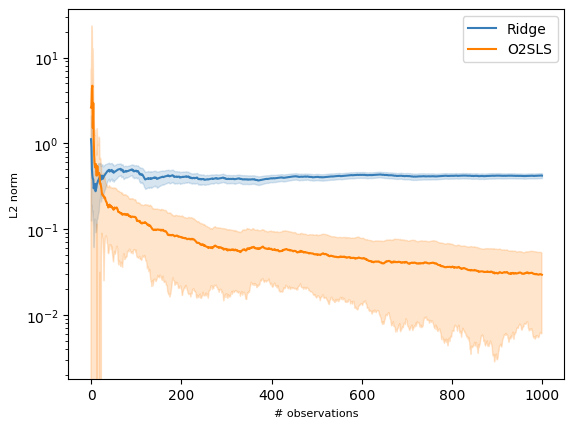

In [22]:
array_beta = np.linalg.norm(store_betas-beta_star.reshape(d,1), axis = 2)
a_mean = array_beta.mean(axis=1)
a_std = array_beta.std(axis=1)

for i in range(len(methods)-2):
    plt.plot(np.arange(T), a_mean[i], color=colors[i], label=methods[i])
    plt.fill_between(np.arange(T), a_mean[i] - a_std[i], a_mean[i] + a_std[i], color=s_colors[i],alpha=0.2)
plt.yscale('log')
# plt.xlim(0,1000)
# plt.ylim(1e-2,10)
plt.xlabel("# observations")
plt.ylabel('L2 norm')
plt.legend()

### Oracle Regret

1) We plot the  ONLINE LOSS 
$\left( \left\langle x_s, \beta_s\right\rangle - y_s \right)^2 $
averarged over the iterations


In [23]:
# compute mean and std online losses for plots
mean_online_loss = np.mean(online_loss_oracle, axis=0)
std_online_loss = np.std(online_loss_oracle, axis=0)

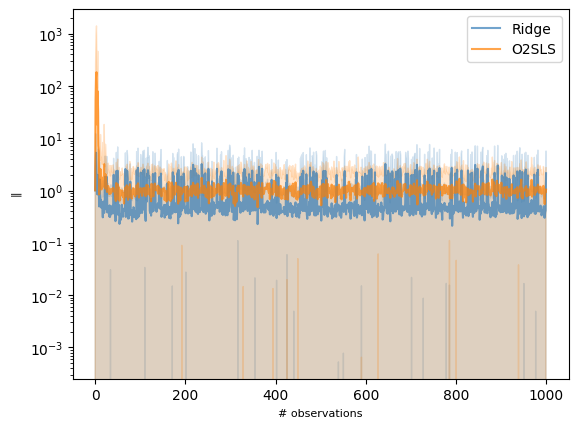

In [24]:
for i in range(len(methods)-2):
    plt.plot(np.arange(T), mean_online_loss[i], color=colors[i], label=methods[i], alpha=0.7)
    plt.fill_between(np.arange(T), mean_online_loss[i] - std_online_loss[i], mean_online_loss[i] + std_online_loss[i], color=s_colors[i],alpha=0.2)
plt.yscale('log')
# plt.xlim(600,1000)
# plt.ylim(1e-2,1e2)
plt.xlabel("# observations")
plt.ylabel('$\| \beta - \beta_t \|$')
plt.legend()
plt.savefig("imgs/or_R_online_loss.pdf", format='pdf')

2. we plot the INSTANTANEOUS REGRET, which is the difference with the ground truth estimator $\left( \left\langle x_t, \beta_t\right\rangle - y_t \right)^2 - \left( \left\langle x_t, \beta \right\rangle - y_t \right)^2
$


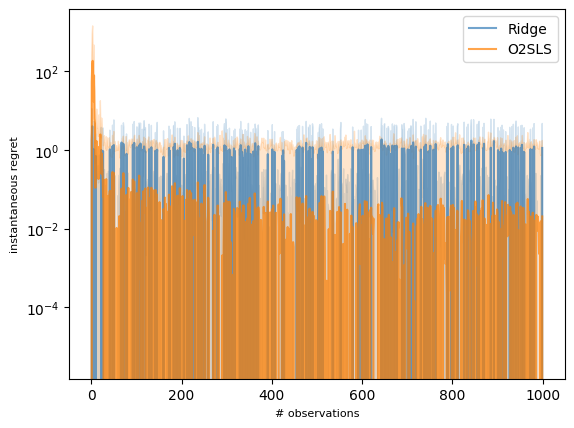

In [25]:
for i in range(len(methods)-2):
    plt.plot(mean_online_loss[i] - mean_online_loss[-1], color=colors[i], label=methods[i],alpha=0.7)
    plt.fill_between(np.arange(T), mean_online_loss[i] - mean_online_loss[-1] - std_online_loss[i], mean_online_loss[i]- mean_online_loss[-1] + std_online_loss[i], color=s_colors[i],alpha=0.2)
plt.yscale('log')
# plt.ylim(-10,10)
plt.legend()
plt.xlabel("# observations")
plt.ylabel('instantaneous regret')
plt.legend()
plt.savefig("imgs/or_R_instantaneous.pdf", format='pdf')

3. We plot the CUMULATIVE REGRET:
$
    \sum_{s=1}^t \left( \left\langle x_s, \beta_s\right\rangle - y_s \right)^2 - \sum_{s=1}^t \left( \left\langle x_s, \beta \right\rangle - y_s \right)^2
$


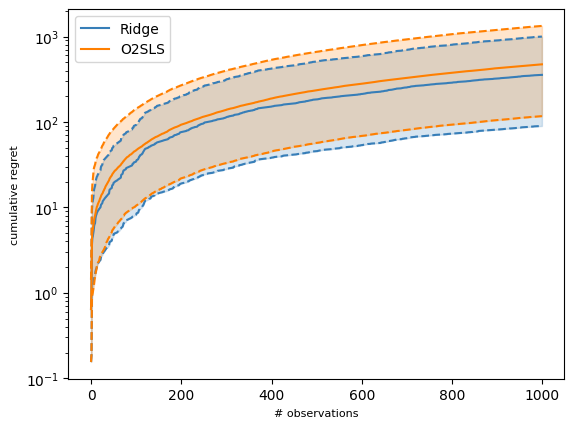

In [26]:
mean_cumulative_online_loss = np.cumsum(np.mean(online_loss_oracle, axis=0), axis=1) 
std_cumulative_online_loss = np.cumsum(np.std(online_loss_oracle, axis=0), axis=1) 

fst_quantile_online_loss = np.cumsum(np.quantile(online_loss_oracle,0.25,axis=0),axis=1)
scd_quantile_online_loss = np.cumsum(np.quantile(online_loss_oracle,0.5,axis=0),axis=1)
thd_quantile_online_loss = np.cumsum(np.quantile(online_loss_oracle,0.75,axis=0),axis=1)

for i in range(len(methods)-2):
    # plt.plot(np.arange(T), mean_cumulative_online_loss[i]-mean_cumulative_online_loss[-1], color=colors[i],label=methods[i])
    # plt.fill_between(np.arange(T), mean_cumulative_online_loss[i] - std_cumulative_online_loss[i]/10, mean_cumulative_online_loss[i] + std_cumulative_online_loss[i]/10, color=s_colors[i],alpha=0.2)   
    
    plt.fill_between(np.arange(T),fst_quantile_online_loss[i],thd_quantile_online_loss[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_online_loss[i],color=colors[i],linestyle="dashed")
    plt.plot(scd_quantile_online_loss[i],color=colors[i],linestyle="solid", label = methods[i])
    plt.plot(thd_quantile_online_loss[i],color=colors[i],linestyle="dashed") 

plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.xlabel("# observations")
plt.ylabel('cumulative regret')
plt.legend()
plt.savefig("imgs/or_R_cumulative.pdf", format='pdf')

### Identification Regret

1) We plot the  INSTANTANEOUS REGRET 
 $\left\langle x_s, \beta_s\right\rangle -  \left\langle x_s, \beta\right\rangle$
averarged over the iterations


In [27]:
# compute mean and std online losses for plots
mean_online_loss = np.mean(online_loss_identification, axis=0)
std_online_loss = np.std(online_loss_identification, axis=0)

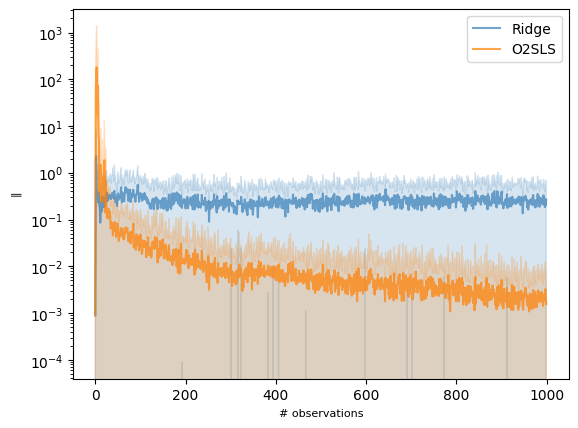

In [28]:
for i in range(len(methods)-2):
    plt.plot(np.arange(T), mean_online_loss[i], color=colors[i], label=methods[i], alpha=0.7)
    plt.fill_between(np.arange(T), mean_online_loss[i] - std_online_loss[i], mean_online_loss[i] + std_online_loss[i], color=s_colors[i],alpha=0.2)
plt.yscale('log')
# plt.xlim(600,1000)
# plt.ylim(1e-2,1e2)
plt.xlabel("# observations")
plt.ylabel('$\| \beta - \beta_t \|$')
plt.legend()
plt.savefig("imgs/id_R_instantaneous.pdf", format='pdf')

2. We plot the CUMULATIVE REGRET:
$
 \sum_{s=1}^t \left( \left\langle x_s, \beta_s\right\rangle -  \left\langle x_s, \beta\right\rangle \right)^2 
$

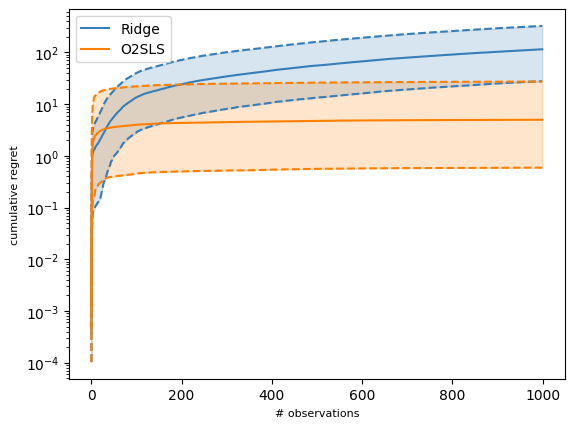

In [29]:
mean_cumulative_online_loss = np.cumsum(np.mean(online_loss_identification, axis=0), axis=1) 
std_cumulative_online_loss = np.cumsum(np.std(online_loss_identification, axis=0), axis=1) 

fst_quantile_online_loss = np.cumsum(np.quantile(online_loss_identification,0.25,axis=0),axis=1)
scd_quantile_online_loss = np.cumsum(np.quantile(online_loss_identification,0.5,axis=0),axis=1)
thd_quantile_online_loss = np.cumsum(np.quantile(online_loss_identification,0.75,axis=0),axis=1)

for i in range(len(methods)-2):
    # plt.plot(np.arange(T), mean_cumulative_online_loss[i]-mean_cumulative_online_loss[-1], color=colors[i],label=methods[i])
    # plt.fill_between(np.arange(T), mean_cumulative_online_loss[i] - std_cumulative_online_loss[i]/10, mean_cumulative_online_loss[i] + std_cumulative_online_loss[i]/10, color=s_colors[i],alpha=0.2)   
    
    plt.fill_between(np.arange(T),fst_quantile_online_loss[i],thd_quantile_online_loss[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_online_loss[i],color=colors[i],linestyle="dashed")
    plt.plot(scd_quantile_online_loss[i],color=colors[i],linestyle="solid", label = methods[i])
    plt.plot(thd_quantile_online_loss[i],color=colors[i],linestyle="dashed") 

plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.xlabel("# observations")
plt.ylabel('cumulative regret')
plt.legend()
plt.savefig("imgs/id_R_cumulative.pdf", format='pdf')